Metody rozpoznawania obrazów - zadanie 2

**Piotr Zawiślan**

_**Kwadraty bez trójkątów (za to z wysokim stężeniem konwolucji)**_

W ramach tego zadania zaimplementujemy prosty mechanizm wykrywania kwadratów na fotografii. Wykorzystamy do tego pierwsze kroki detekcji krawędzi metodą Canny'ego oraz transformatę Hougha (po więcej informacji na temat obu technik sięgnij do PDFa z zagadnieniami i materiałami). Ponownie jednak - nie to jest naszym nadrzędnym celem. Najważniejsze jest to, by przy okazji nauczyć się implementować (w swoim #ulubionymframeworku) różne rodzaje konwolucji oraz dowiedzieć się jak obserwować efekty ich stosowania.

Obie części zadania implementujemy z wykorzystaniem wybranego tydzień wcześniej frameworku. Każda ze wspomnianych metod ma w sieci wiele gotowych implementacji, ale znów - nie taki jest cel tego zadania.

- W przypadku punktów oznaczonych ikoną ⌨️ poinformuj w jaki sposób je zrealizowałeś - wspomnij kluczowe klasy/metody/funkcje lub załącz powiązany fragment kodu źródłowego.
- W przypadku punktów oznaczonych ikoną 🖼 załącz w raporcie obraz przedstawiający stan kanału będącego wynikiem danej operacji.

In [1]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
np.random.seed(311)

PLOTS_PATH = os.path.join(".", "plots")
os.makedirs(PLOTS_PATH, exist_ok=True)

In [4]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(PLOTS_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
def plot_image(image: torch.Tensor, title=None, save=False, fig_id=None, cmap='gray'):
    ndim = np.array(image.detach()).ndim
    if ndim == 2:
        plt.imshow(image.detach().numpy(), cmap=cmap)
    elif ndim == 3:
        if image.shape[0] == 1:
            plt.imshow(image[0].detach().numpy(), cmap=cmap)
        else:
            plt.imshow(np.moveaxis(image.detach().numpy(), 0, -1))
    else:
        return
    if title:
        plt.title(title)
    plt.axis("off")
    if save and fig_id is not None:
        save_fig(fig_id)
    plt.show()

In [6]:
def plot_matrix(image: torch.Tensor, title=None, save=False, fig_id=None):
    ndim = np.array(image.detach()).ndim
    if ndim == 2:
        plt.matshow(image.detach().numpy())
    elif ndim == 3:
        if image.shape[0] == 1:
            plt.matshow(image[0].detach().numpy())
        else:
            plt.matshow(np.moveaxis(image.detach().numpy(), 0, -1))
    else:
        return
    if title:
        plt.title(title)
    plt.axis("off")
    if save and fig_id is not None:
        save_fig(fig_id)
    plt.show()

# Najpierw poszukajmy krawędzi...

1. Zaczynamy od wczytania załączonego do zadania obrazu `furniture.png`. Tym razem nie ma potrzebny poddawania go na starcie intensywnej obróbce - upewnij się tylko, że można go użyć jako wejścia do zdefiniowanego dalej potoku przetwarzania. Warto jedynie przeskalować wszystkie wartości w pikselach tak, by mieściły się w zakresie od 0 do 1 (podobnie jak w poprzednim zadaniu - wystarczy podzielić je przez 255).

In [7]:
from torchvision.io import read_image

furniture_tensor = (read_image("furniture.png") / 255.).double()
print(furniture_tensor.shape)

torch.Size([3, 541, 555])


Saving figure image_rgb


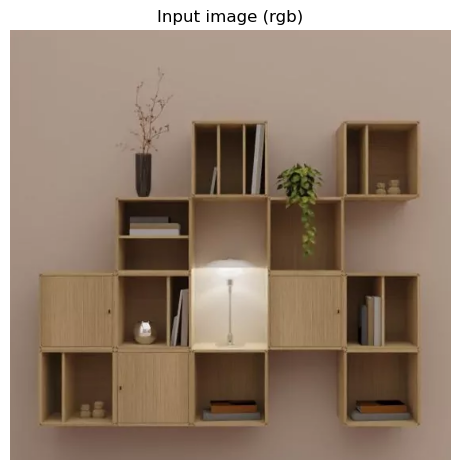

In [8]:
plot_image(furniture_tensor, title='Input image (rgb)', save=True, fig_id='image_rgb')

2. Obraz jest kolorowy i składa się z trzech kanałów - czerwonego, zielonego i niebieskiego. Dla uproszczenia późniejszych kroków zamieńmy go na wariant korzystający ze skali szarości - czyli składający się tylko z jednego kanału.

    - W tym celu zastosuj konwolucję 1x1 z jednym kanałem wyjściowym. Przypisz odpowiednie wagi do wykorzystywanego filtra tak, by wynik był średnią ważoną wartości RGB dla każdego piksela (proporcje poszczególnych kolorów możesz dobrać "na oko" oceniając po prostu jakość wyniku). Dopilnuj by użyty był właściwy padding i stride - chcemy, by wynikowy obraz był tego samego rozmiaru co wejściowy. [⌨️🖼]

In [9]:
from torch import nn

filter_arr = [[ 
    [[0.2]],
    [[0.6]],
    [[0.6]]
]]
# kernel_shape: (out_channels, in_channels, kernel[0], kernel[1])
print(f"Kernel shape: {np.array(filter_arr).shape}")
reduce_ch_filter = torch.tensor(filter_arr).double()

reduce_ch_conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=1, 
                           padding='same', bias=False, padding_mode='replicate')
reduce_ch_conv.weight.data = reduce_ch_filter

furniture_grey = reduce_ch_conv(furniture_tensor)  # furniture_tensor[0])
print(f"Result shape: {furniture_grey.shape}")

Kernel shape: (1, 3, 1, 1)
Result shape: torch.Size([1, 541, 555])


In [10]:
def min_max_scale(x):
    return (x - x.min()) / (x.max() - x.min())

In [11]:
# min-max scaling
furniture_grey = min_max_scale(furniture_grey)

Saving figure image_grey


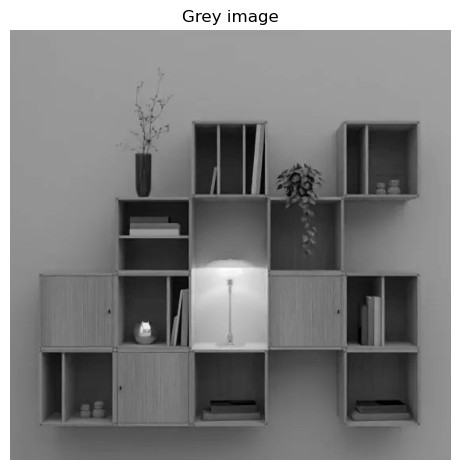

In [12]:
plot_image(furniture_grey, title='Grey image', save=True, fig_id='image_grey')

3.  Obraz jest nieco za duży. Chociaż nie jest to praktyczne podejście do tego problemu,
postaramy się zmniejszyć jego rozmiar z użyciem tzw. poolingu - operacji, która zastępuje
każde okno o zadanym kształcie jednym nowym pikselem. W tym przypadku wystarczy nam
okno 4 x 4. Pozostaje jeszcze pytanie o to, jakiego typu pooling wybrać - average czy max?
Zdecyduj się na jeden z nich (i uzasadnij swój wybór). [⌨️🖼]

In [13]:
max_pool_4 = nn.MaxPool2d(kernel_size=4, stride=4)
furniture_max_pooled = max_pool_4(furniture_grey)
print(f"Result shape: {furniture_max_pooled.shape}")

Result shape: torch.Size([1, 135, 138])


In [14]:
avg_pool_4 = nn.MaxPool2d(kernel_size=4, stride=4)
furniture_avg_pooled = avg_pool_4(furniture_grey)
print(f"Result shape: {furniture_avg_pooled.shape}")

Result shape: torch.Size([1, 135, 138])


Saving figure image_max_pooled


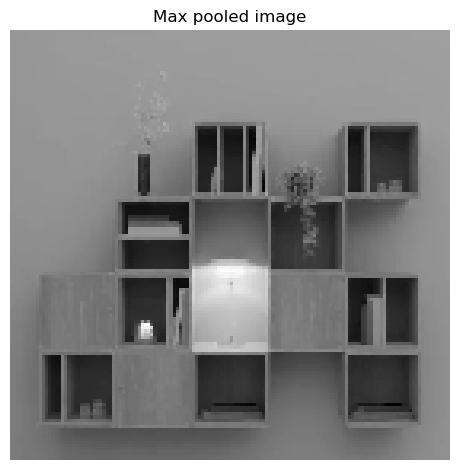

In [15]:
plot_image(furniture_max_pooled, title='Max pooled image', save=True, fig_id='image_max_pooled')

Saving figure image_avg_pooled


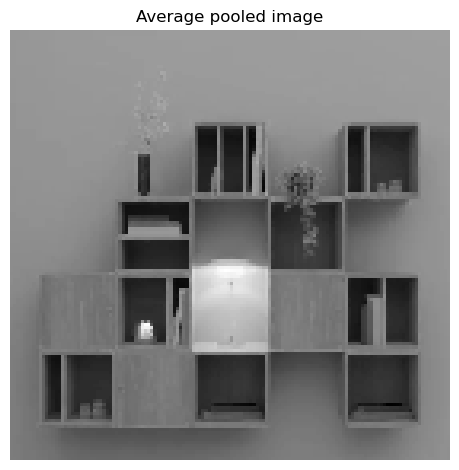

In [16]:
plot_image(furniture_avg_pooled, title='Average pooled image', save=True, fig_id='image_avg_pooled')

4. Obraz jest już mały i czarno-biały, teraz pora pozbyć się niepotrzebnych szumów i detali. W tym celu zastosujemy rozmycie gaussowskie.
    - Zacznij od przygotowania kodu, który dla zadanego rozmiaru filtra n przygotuje tablicę $n \times n$ zawierającą zgodne z rozkładem normalnym współczynniki - największe na środku, stopniowo malejące im bliżej krawędzi. Suma całej tablicy powinna oczywiście wynosić 1.
    - Następnie na zwróconym w poprzednim kroku obrazie zastosuj konwolucję n x n wykorzystującą przygotowaną chwilę wcześniej macierz wag. Wyjściowy obraz powinien być zgodny z oryginałem co do rozmiaru - lecz estetycznie rozmyty. [⌨️🖼]
    - Poeksperymentuj z różnymi wartościami n - dobierz taki rozmiar filtru rozmywającego, który usunie drobne elementy, ale zachowa ogólny sens tego co na obrazie.

In [17]:
def get_gaussian_kernel(n: int, sigma=1):
    s = n // 2
    xs, ys = np.mgrid[-s:s+1, -s:s+1]
    K = np.exp( -((xs**2 + ys**2) / (2.0*sigma**2)) ) * (1 / (2.0 * np.pi * sigma**2))
    return torch.from_numpy(K)

In [18]:
k_size = 5

kernel = get_gaussian_kernel(k_size).unsqueeze(0).unsqueeze(0)
print(f"Kernel shape: {kernel.shape}")

blur_conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=k_size, stride=1, 
                      padding='same', bias=False, padding_mode='replicate')
blur_conv.weight.data = kernel

furniture_blurred = blur_conv(furniture_max_pooled)
print(f"Result shape: {furniture_blurred.shape}")

Kernel shape: torch.Size([1, 1, 5, 5])
Result shape: torch.Size([1, 135, 138])


Saving figure image_blurred


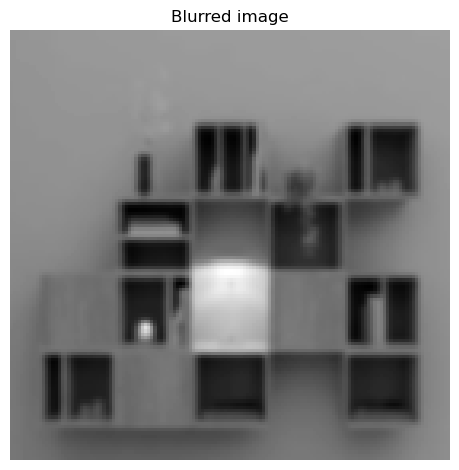

In [19]:
plot_image(furniture_blurred, title='Blurred image', save=True, fig_id='image_blurred')

5. Kolejny etap to ustalenie, w których regionach obrazu gradient intensywności jest największy.

- By poznać poziomą i pionową składową gradientu przetwórz (korzystając z konwolucji) aktualny stan obrazu przez wspomniane na zajęciach filtry Sobela. Zauważ, że tym razem na wyjściu uzyskujemy dwa kanały! [🖼]
    
```
            [1, 2, 1               [1, 0,-1
             0, 0, 0                2, 0,-2
            -1,-2,-1]               1, 0,-1]
```
- Scal uzyskane kanały w jeden, który reprezentuje intensywność gradientu (czyli długość
odpowiedniego wektora - obliczaną w zgodnie z normą Euklidesa). W tym celu kolejno. [⌨️]
    1. Podnieś wszystkie wartości w obu warstwach do kwadratu.
    2. Zsumuj je - możesz użyć konwolucji 1x1 lub dowolnej innej wygodnej metody.
    3. Wyciągnij pierwiastek z sumy.

- Krawędzie to miejsca gwałtownych przejść tonalnych - można je rozpoznać po bardzo dużych gradientach. Aby pozostawić na obrazie krawędzie, odfiltruj regiony z niewielkim gradientem. [🖼]
    1. Można tu użyć np. tzw. progowanego ReLU (większość frameworków oferuje gotową implementację). Ta operacja sprowadza się w tym przypadku do "zachowaj wartość, jeżeli jest większa niż próg - w przeciwnym wypadku zastąp ją zerem".
    2. Poeksperymentuj z różnymi poziomami odcięcia i znajdź taki, dla którego znalezione krawędzie są tolerowalnej jakości.
    3. Na koniec znormalizuj wartości w kanale tak, by zawierały się w przedziale od 0 do 1.


In [20]:
sobel_kernel_h = [[[1, 2, 1], [0, 0, 0], [-1,-2,-1]]]
sobel_kernel_w = [[[1, 0,-1], [2, 0,-2], [1, 0,-1]]]

sobel_kernels_stacked = torch.tensor([sobel_kernel_h, sobel_kernel_w]).double()

In [21]:
sobel_kernels_stacked.shape

torch.Size([2, 1, 3, 3])

In [22]:
gradient_conv = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3,
                         padding='same', bias=False, padding_mode='replicate', groups=1)
gradient_conv.weight.data = sobel_kernels_stacked

result = gradient_conv(furniture_blurred)

In [23]:
gradient_h = min_max_scale(result[0])
gradient_w = min_max_scale(result[1])

Saving figure image_grad_h


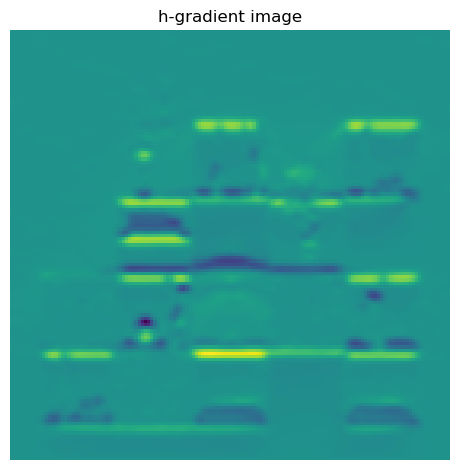

In [24]:
plot_image(gradient_h, cmap='viridis', title='h-gradient image', save=True, fig_id='image_grad_h')

Saving figure image_grad_w


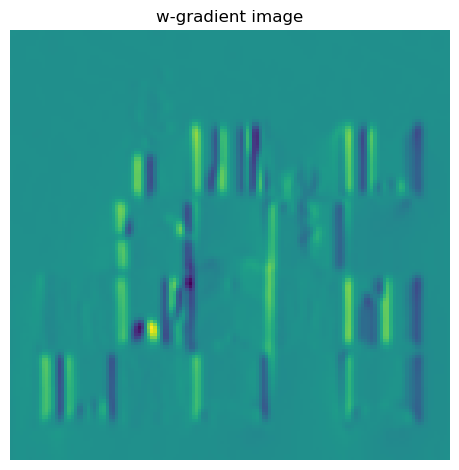

In [25]:
plot_image(gradient_w, cmap='viridis', title='w-gradient image', save=True, fig_id='image_grad_w')

In [26]:
gradient_length = min_max_scale((gradient_h**2 + gradient_w**2).sqrt())

Saving figure image_grad_length


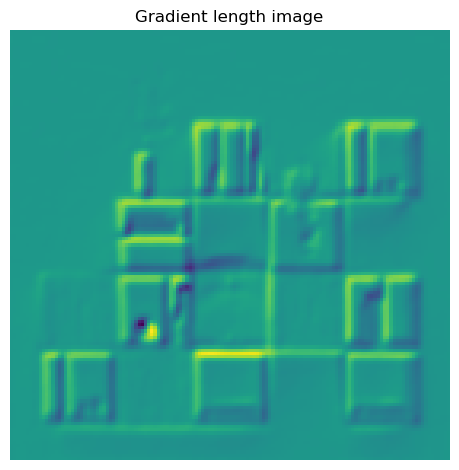

In [27]:
plot_image(gradient_length, cmap='viridis', title='Gradient length image', 
           save=True, fig_id='image_grad_length')

In [28]:
# threshold
gradient_length_t = gradient_length.clone()
threshold_func = nn.Threshold(threshold=0.57, value=0)
gradient_length_t = threshold_func(gradient_length_t)

Saving figure image_grad_length_t


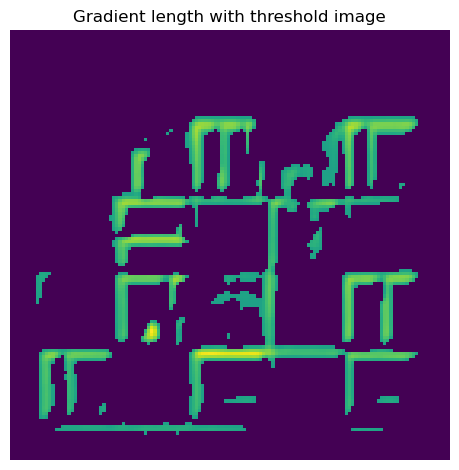

In [30]:
plot_image(gradient_length_t, cmap='viridis', title='Gradient length with threshold image', 
           save=True, fig_id='image_grad_length_t')

6. To koniec części odpowiedzialnej za wykrywanie krawędzi. Jeżeli znasz metodę Canny'ego to na pewno zauważyłeś, że pominięto niektóre z jej istotnych kroków. Jeżeli chcesz, to możesz przetestować drugą połowę zadania z wyższej jakości krawędziami wykrytymi przez gotową implementację tego algorytmu - i sprawdzić na ile poprawią się finalne rezultaty - ale jest to zupełnie opcjonalne!

# ...a potem sprawdźmy, czy układają się w kwadratowe kształty.

6. Teraz wykorzystamy transformatę Hougha - każdy piksel musi zagłosować na możliwe położenia kwadratu, którego jest częścią. Środki takich kwadratów znajdują się...również na kwadracie. Dlatego głosowanie można przeprowadzić korzystając z operacji znanej jako transponowana konwolucja.
- Tak naprawdę nie wiemy jednak, jakiego rozmiaru są szukane przez nas kwadraty. Dlatego będziemy zmuszeni użyć nie jednej, a wielu konwolucji transponowanych - każda z nich reprezentować będzie inny rozmiar poszukiwanych kwadratów. Poniżej zaprezentowane są przykładowe filtry do wykorzystania w tym kroku (dla kwadratów o rozmiarach 3x3 oraz 5x5). Wykorzystaj technikę by uzyskać przestrzeń głosowania dla wybranego zakresu rozmiarów (np. od 16x16 do 32x32). [⌨️🖼]
```
            [1, 1, 1               [1, 1, 1, 1, 1
             1, 0, 1                1, 0, 0, 0, 1
             1, 1, 1]               1, 0, 0, 0, 1
                                    1, 0, 0, 0, 1
                                    1, 1, 1, 1, 1]
```
- Jak wygląda przestrzeń głosowania dla każdego z rozważanych rozmiarów kwadratu? [🖼]

In [31]:
edges_image = gradient_length_t.clone().detach().unsqueeze(0)

In [32]:
edges_image.shape

torch.Size([1, 135, 138])

In [33]:
from torch.nn.functional import pad

def get_hough_square_kernels(a_min=16, a_max=32):
    n_kernels = a_max - a_min + 1
    kernels = torch.empty(n_kernels, a_max, a_max)
    inner_size = a_min - 2
    for i in range(n_kernels):
        inner_zeros = torch.zeros(inner_size, inner_size)
        zeros_with_pad = pad(inner_zeros,  pad=(1, 1, 1, 1), mode='constant', value=1)
        
        pad_big = (a_max - inner_size - 1) // 2
        pad_small = (a_max - inner_size - 2) // 2
        K = pad(zeros_with_pad, pad=(pad_small, pad_big, pad_small, pad_big),
                          mode='constant', value=0)
        kernels[i] = K
        inner_size += 1
    return kernels

In [34]:
get_hough_square_kernels().shape

torch.Size([17, 32, 32])

In [35]:
def get_voting_spaces(image: torch.Tensor, a_min=16, a_max=32):
    n_kernels = a_max - a_min + 1
    kernels = get_hough_square_kernels(a_min, a_max).unsqueeze(0).double()
    padding_size = (a_max - 1) // 2
    hough_squares_transposed_conv = nn.ConvTranspose2d(in_channels=1, 
                                                       out_channels=n_kernels, 
                                                       kernel_size=a_max,
                                                       stride=1,
                                                       padding=(padding_size, padding_size),
                                                       bias=False,
                                                       padding_mode='zeros'
                                                      )
    hough_squares_transposed_conv.weight.data = kernels
    return hough_squares_transposed_conv(image)

In [36]:
voting_spaces = get_voting_spaces(edges_image)
voting_spaces.shape

torch.Size([17, 136, 139])

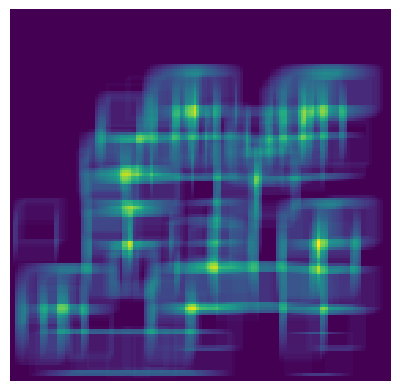

In [37]:
plot_matrix(voting_spaces[0])

Saving figure voting_spaces


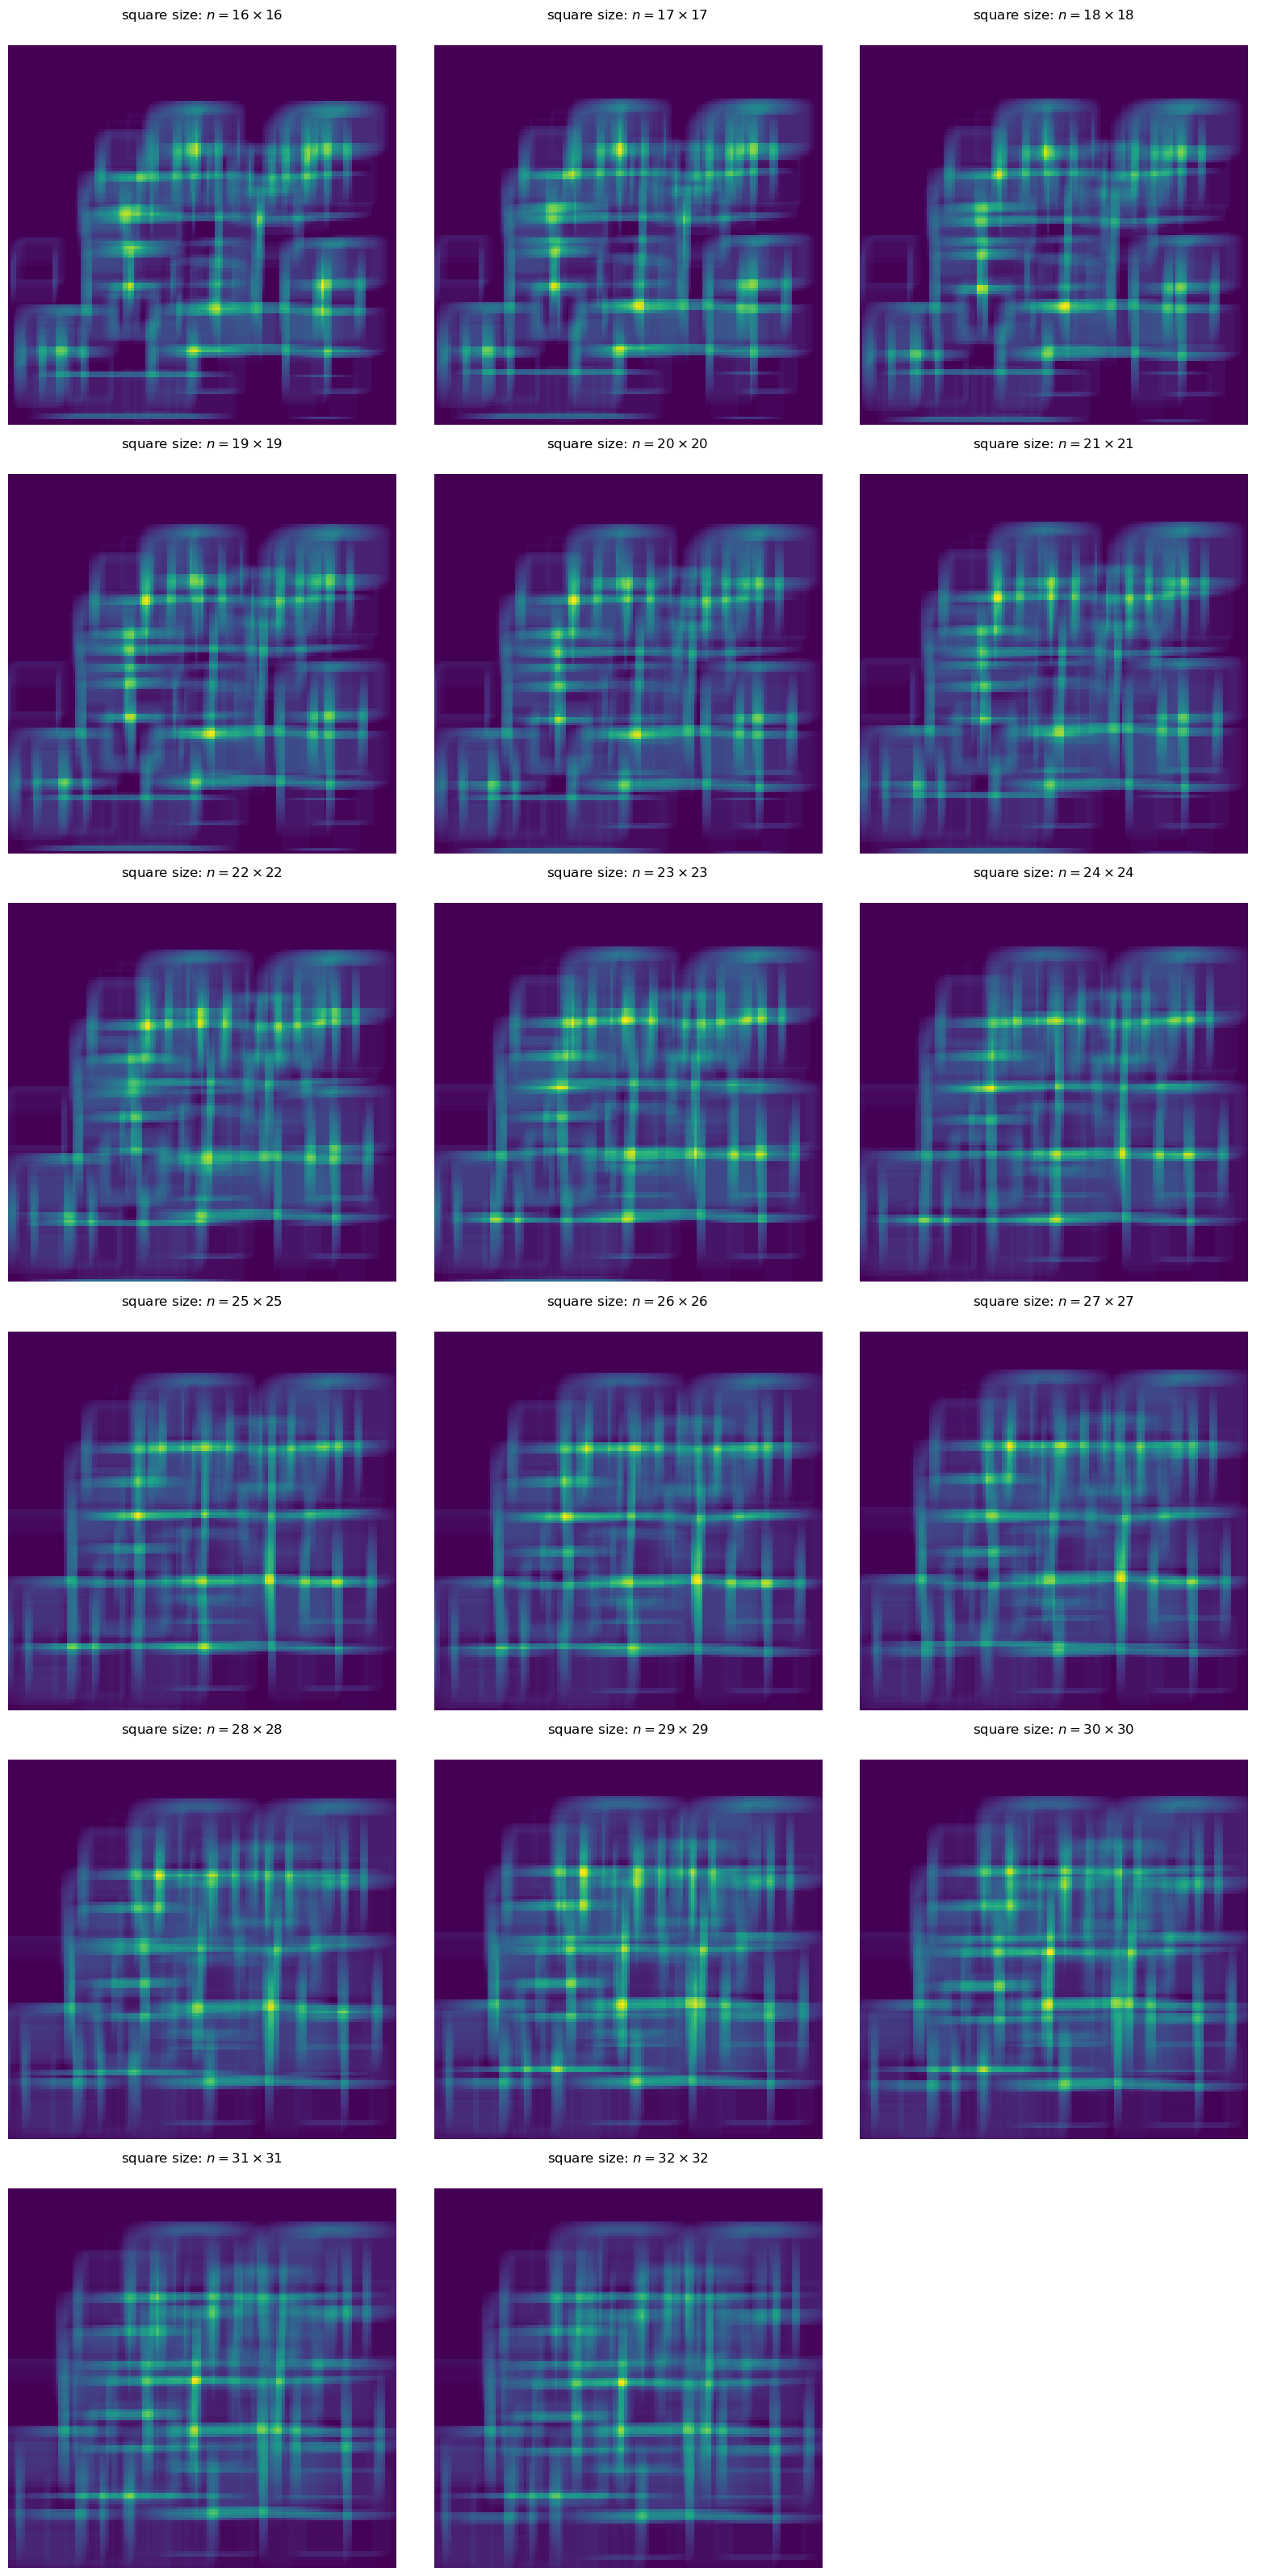

In [38]:
a_min = 16
n_subplots = voting_spaces.shape[0]
cols = 3
rows = n_subplots // cols if n_subplots % cols == 0 else (n_subplots // cols) + 1
fig, axes = plt.subplots(rows, cols)

fig.set_size_inches((16, 32))

for i in range(rows * cols):
    r = i // cols
    c = i % cols
    if i < n_subplots:
        axes[r, c].axis('off')
        axes[r, c].matshow(voting_spaces[i].detach())
        axes[r, c].set_title(f"square size: $n = {a_min+i} \\times {a_min+i}$")
    else:
        axes[r, c].axis('off')
save_fig('voting_spaces')

- Maksima nowo powstałych kanałów reprezentują środki znalezionych kwadratów. Odfiltruj je w podobny sposób jak w przypadku krawędzi w poprzedniej sekcji (możesz pozwolić sobie na bardzo wysoki próg - interesują nas tylko najistotniejsze punkty, dosłownie kilka kropek - a i to tylko na niektórych kanałach). Pamiętaj, że próg warto dostosować do rozmiaru wykrywanego kwadratu - te większe mają szansę dostać proporcjonalnie więcej głosów.

In [39]:
voting_spaces_clean = voting_spaces.clone()
kappa = 2.05
b = 16

for i in range(voting_spaces_clean.shape[0]):
    t_func = nn.Threshold(threshold=kappa * (i + b), value=0)
    voting_spaces_clean[i] = t_func(voting_spaces_clean[i])
    
print(f'Squares detected: {voting_spaces_clean.count_nonzero()}')

Squares detected: 33


Saving figure voting_spaces_maxima


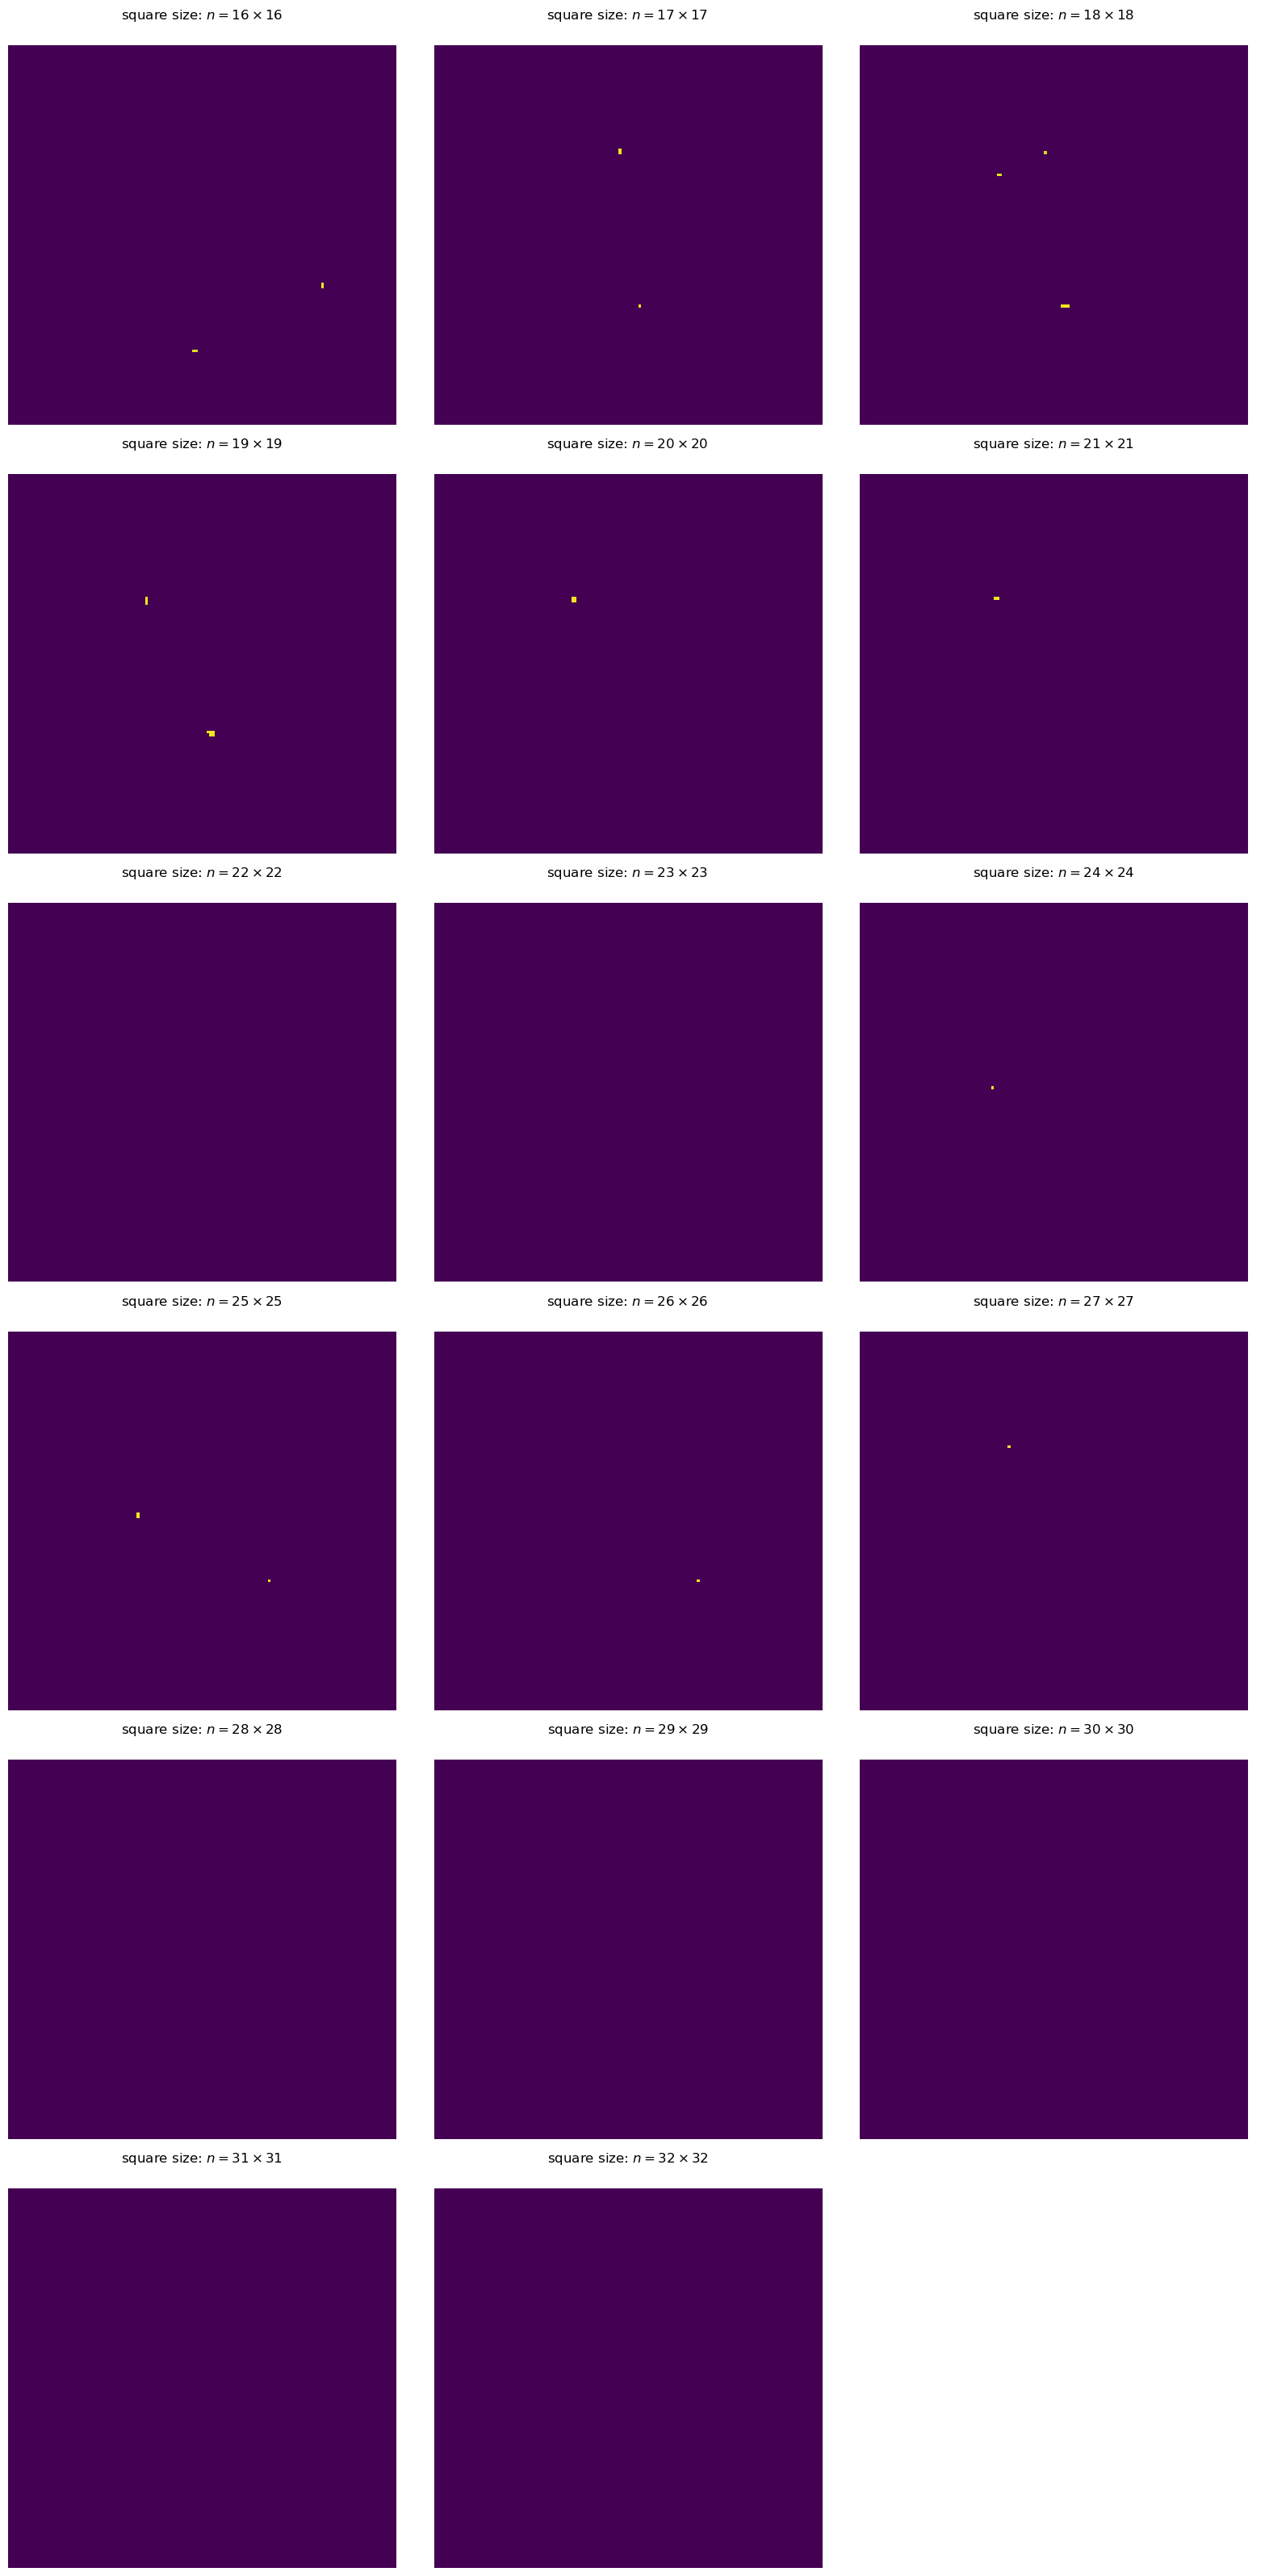

In [40]:
a_min = 16
n_subplots = voting_spaces_clean.shape[0]
cols = 3
rows = n_subplots // cols if n_subplots % cols == 0 else (n_subplots // cols) + 1
fig, axes = plt.subplots(rows, cols)

fig.set_size_inches((16, 32))

for i in range(rows * cols):
    r = i // cols
    c = i % cols
    if i < n_subplots:
        axes[r, c].axis('off')
        axes[r, c].matshow(voting_spaces_clean[i].detach())
        axes[r, c].set_title(f"square size: $n = {a_min+i} \\times {a_min+i}$")
    else:
        axes[r, c].axis('off')
save_fig('voting_spaces_maxima')

- Ponownie zastosuj konwolucję transponowaną, z tymi samymi kwadratowymi filtrami co poprzednio - teraz każda odkryta w poprzednim kroku kropka zostanie zastąpiona reprezentacją rzeczywiście wykrytego kwadratu (im mocniejsze maksimum, tym jaśniejszy taki kwadrat). [🖼]
- Ta operacja może być dość kosztowna - na etapie implementacji zacznij od proof of concept wykorzystującego tylko fragment wejściowego obrazu. Jeśli wykonujesz zadanie na CPU, to możesz nawet na samym starcie zmniejszyć cały obraz dwukrotnie (i w ten sam sposób zredukować rozmiary filtrów powyżej).

In [41]:
def voting_spaces_to_square(v_spaces: torch.Tensor, a_min=16, a_max=32):
    n_kernels = a_max - a_min + 1
    kernels = get_hough_square_kernels(a_min, a_max).unsqueeze(1).double()
    padding_size = (a_max - 1) // 2
    hough_squares_transposed_conv = nn.ConvTranspose2d(in_channels=n_kernels, 
                                                       out_channels=1, 
                                                       kernel_size=a_max,
                                                       stride=1,
                                                       padding=(padding_size, padding_size),
                                                       bias=False,
                                                       padding_mode='zeros'
                                                      )
    hough_squares_transposed_conv.weight.data = kernels
    return hough_squares_transposed_conv(v_spaces)

In [42]:
detected_squares = voting_spaces_to_square(voting_spaces_clean).squeeze(0)

In [43]:
detected_squares.shape

torch.Size([137, 140])

In [44]:
upscaling_func = nn.Upsample(size=furniture_tensor[0].shape, mode='nearest')
squares_upscaled = upscaling_func(detected_squares.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)

In [45]:
squares_upscaled.shape

torch.Size([541, 555])

Saving figure detected_squares


C:\Users\User\AppData\Local\Temp\ipykernel_20856\2703726573.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


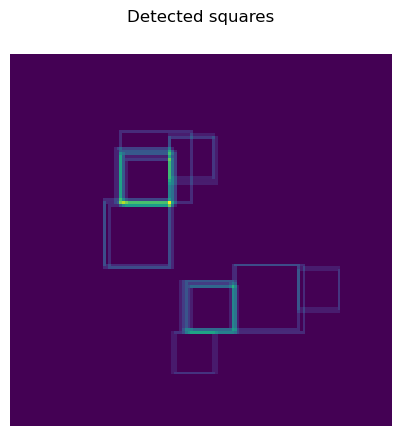

In [46]:
plot_matrix(squares_upscaled, title='Detected squares', save=True, fig_id='detected_squares')

In [47]:
squares_ones = torch.where(squares_upscaled > 0., 1, 0)

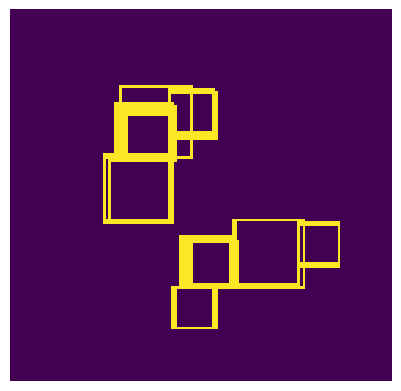

In [48]:
plot_matrix(squares_ones)

7. Na koniec scal uzyskane wyniki z pierwotnym obrazem. Zwiększ ich rozdzielczość tak, by znów zgadzała się z oryginalną (korzystając z dowolnego zaimplementowanego już upscalingu), a następnie nałóż na startowy obraz, np. wzmacniając kanał zielony i osłabiając pozostałe - wtedy odnalezione kwadraty będą widoczne na końcowej fotografii. Czy ich pozycje mają sens? Wypróbuj swoją implementacją na innym obrazie zawierającym kwadratowe elementy - czy efekty są podobnej jakości? [🖼]

In [49]:
def merge_results(im_tensor: torch.Tensor, squares: torch.Tensor, rgb_ws=(0.5, 0.5, 0.5)):
    im = im_tensor.clone()
    for i in range(3):
        im[i] = (im[i] * rgb_ws[i])
    im[1] += (squares * 10)
    return im

In [50]:
res_image = merge_results(furniture_tensor, squares_ones)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving figure detected_squares_on_image


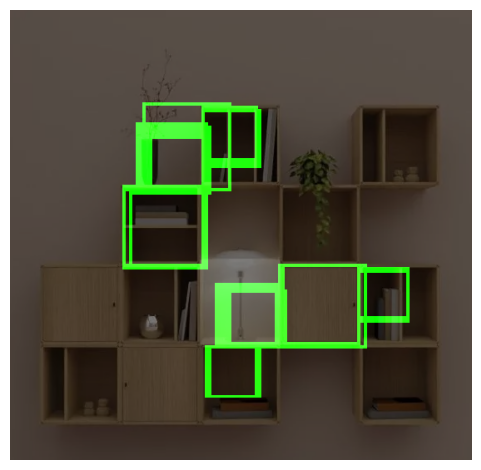

In [51]:
plot_image(res_image, save=True, fig_id='detected_squares_on_image')

8. Prawdopodobnie finalny efekt pozostawia sporo do życzenia - zapewne pojawiły się nietypowe artefakty, jedne kwadraty zostały wykryte wielokrotnie, inne zaś w ogóle. Jak myślisz, które etapy procedury miały najbardziej negatywny wpływ na wynik (jest to przecież wariant silnie okrojony)? Jak można by ją usprawnić (opowiedz, nie implementuj ;])?

---

**Drugi obraz**

---

In [52]:
mosaic_tensor = (read_image("squares_mosiac.jpg") / 255.).double()
mosaic_tensor.shape

torch.Size([3, 750, 1155])

Saving figure image2_rgb


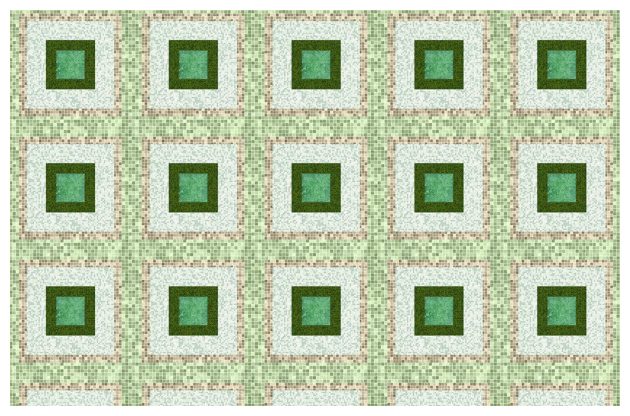

In [53]:
plot_image(mosaic_tensor, save=True, fig_id='image2_rgb')

In [54]:
mosaic_tensor.shape

torch.Size([3, 750, 1155])

In [55]:
from torch import nn

filter_arr = [[ 
    [[0.2]],
    [[0.6]],
    [[0.6]]
]]
# kernel_shape: (out_channels, in_channels, kernel[0], kernel[1])
print(f"Kernel shape: {np.array(filter_arr).shape}")
reduce_ch_filter = torch.tensor(filter_arr).double()

reduce_ch_conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=1, 
                           padding='same', bias=False, padding_mode='replicate')
reduce_ch_conv.weight.data = reduce_ch_filter

mosaic_grey = reduce_ch_conv(mosaic_tensor)
print(f"Result shape: {mosaic_grey.shape}")

# min-max scaling
mosaic_grey = min_max_scale(mosaic_grey)

Kernel shape: (1, 3, 1, 1)
Result shape: torch.Size([1, 750, 1155])


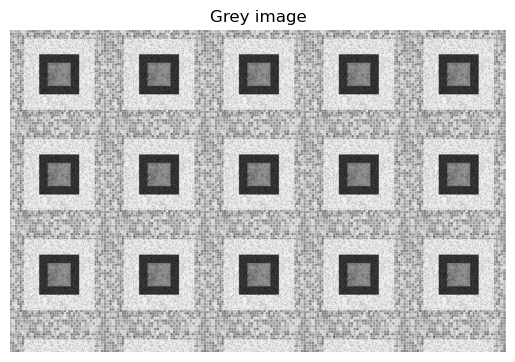

In [56]:
plot_image(mosaic_grey, title='Grey image')

In [57]:
max_pool_6 = nn.MaxPool2d(kernel_size=6, stride=6)
mosaic_max_pooled = max_pool_6(mosaic_grey)
print(f"Result shape: {mosaic_max_pooled.shape}")

Result shape: torch.Size([1, 125, 192])


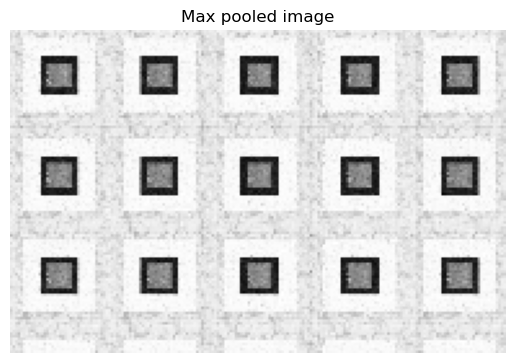

In [58]:
plot_image(mosaic_max_pooled, title='Max pooled image')

In [59]:
k_size = 5

kernel = get_gaussian_kernel(k_size).unsqueeze(0).unsqueeze(0)
print(f"Kernel shape: {kernel.shape}")

blur_conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=k_size, stride=1, 
                      padding='same', bias=False, padding_mode='replicate')
blur_conv.weight.data = kernel

mosaic_blurred = blur_conv(mosaic_max_pooled)
print(f"Result shape: {mosaic_blurred.shape}")

Kernel shape: torch.Size([1, 1, 5, 5])
Result shape: torch.Size([1, 125, 192])


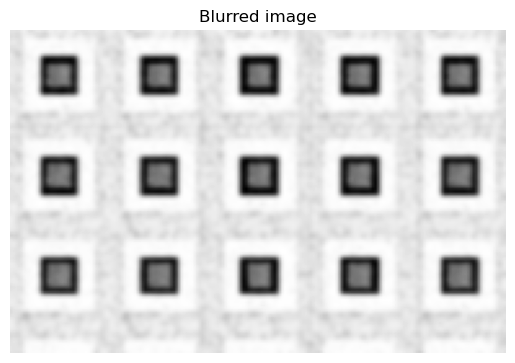

In [60]:
plot_image(mosaic_blurred, title='Blurred image')

In [61]:
gradient_conv = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3,
                         padding='same', bias=False, padding_mode='replicate', groups=1)
gradient_conv.weight.data = sobel_kernels_stacked

result = gradient_conv(mosaic_blurred)

gradient_h = min_max_scale(result[0])
gradient_w = min_max_scale(result[1])

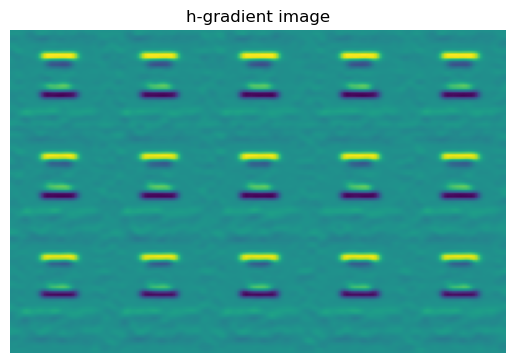

In [62]:
plot_image(gradient_h, cmap='viridis', title='h-gradient image')

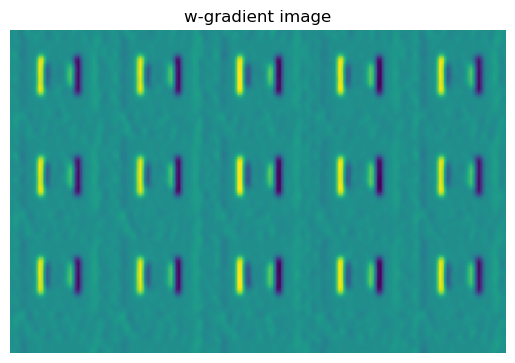

In [63]:
plot_image(gradient_w, cmap='viridis', title='w-gradient image')

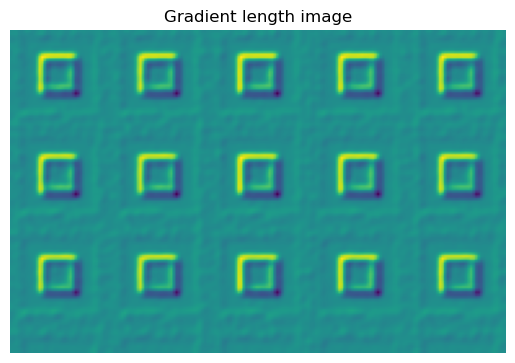

In [64]:
gradient_length = min_max_scale((gradient_h**2 + gradient_w**2).sqrt())

plot_image(gradient_length, cmap='viridis', title='Gradient length image')

Saving figure image2_grad_length_t


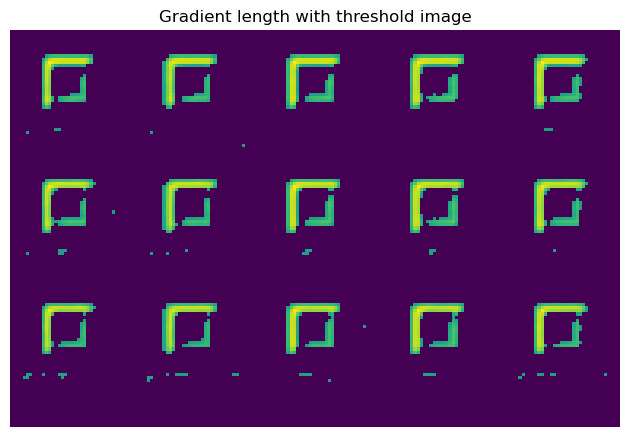

In [65]:
# threshold
gradient_length_t = gradient_length.clone()
threshold_func = nn.Threshold(threshold=0.56, value=0)
gradient_length_t = threshold_func(gradient_length_t)

plot_image(gradient_length_t, cmap='viridis', title='Gradient length with threshold image', 
           save=True, fig_id='image2_grad_length_t')

In [66]:
edges_image = gradient_length_t.clone().detach().unsqueeze(0)

In [67]:
voting_spaces = get_voting_spaces(edges_image)
voting_spaces.shape

torch.Size([17, 126, 193])

In [68]:
voting_spaces_clean = voting_spaces.clone()
kappa = 1.68
b = 16

for i in range(voting_spaces_clean.shape[0]):
    t_func = nn.Threshold(threshold=kappa * (i + b), value=0)
    voting_spaces_clean[i] = t_func(voting_spaces_clean[i])
    
print(f'Squares detected: {voting_spaces_clean.count_nonzero()}')

Squares detected: 16


In [69]:
detected_squares = voting_spaces_to_square(voting_spaces_clean).squeeze(0)
upscaling_func = nn.Upsample(size=mosaic_tensor[0].shape, mode='nearest')
squares_upscaled = upscaling_func(detected_squares.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)

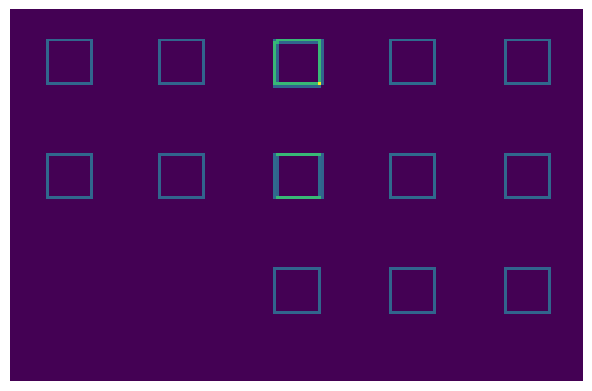

In [70]:
plot_matrix(squares_upscaled)

In [71]:
squares_ones = torch.where(squares_upscaled > 0., 1, 0)
res_image = merge_results(mosaic_tensor, squares_ones)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving figure detected_squares_on_image2


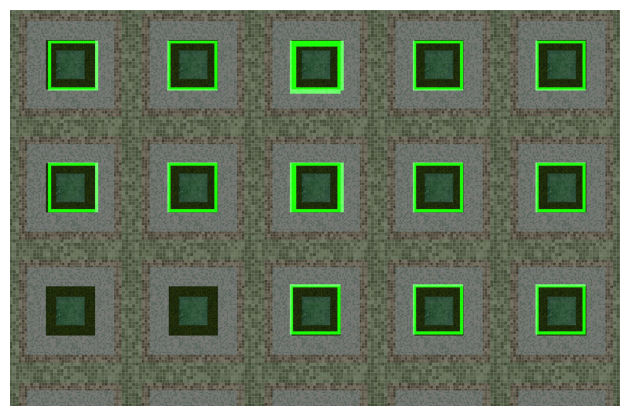

In [72]:
plot_image(res_image, save=True, fig_id='detected_squares_on_image2')